In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tables import *
import h5py
import os
import pandas as pd
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import statistics


# **Two visualizations of the raw data**


Plots of Energy, s_tract and f_tract features of two files, frecuency vs time

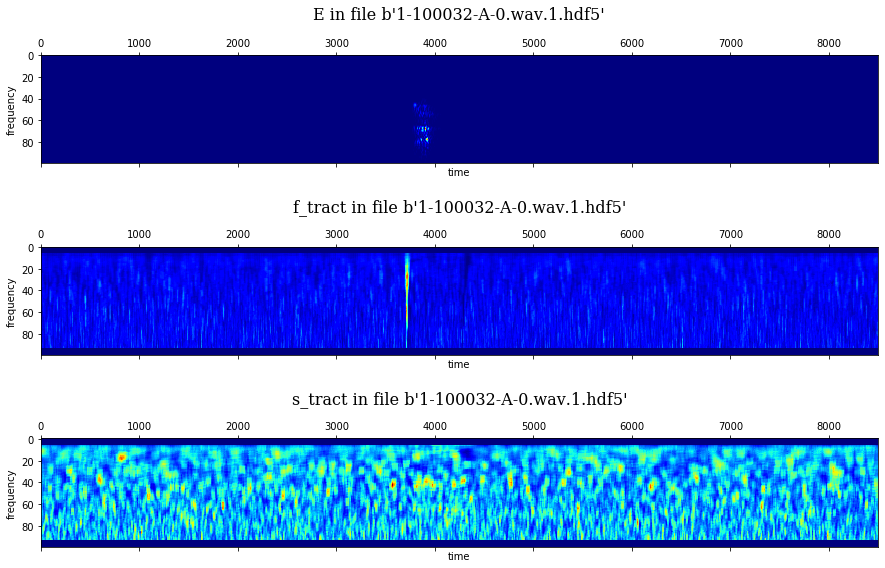

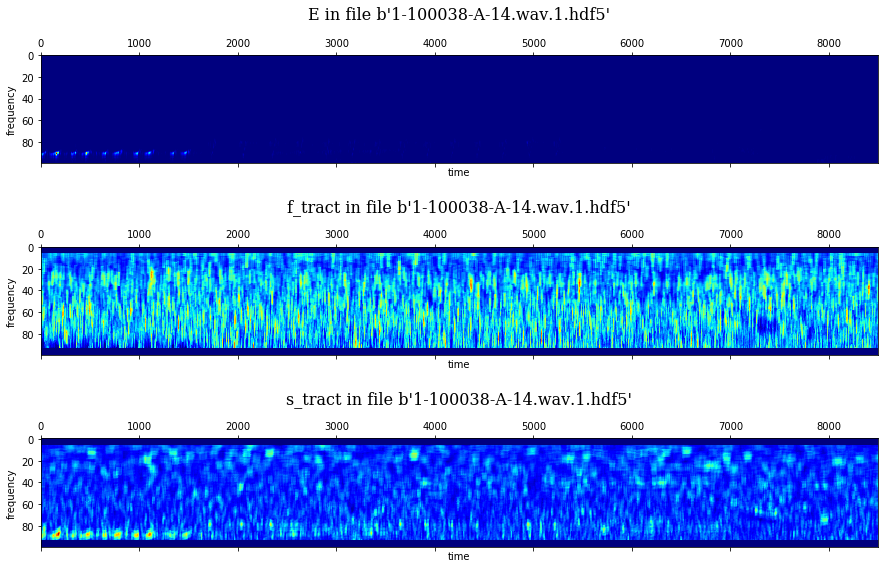

In [37]:
directory2 = os.fsencode("/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/")
aspec = 11.00
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
pad=30
cnt2 = 0
for file in os.listdir(directory2):
    path3 = os.path.join(directory2, file)
    f3 = h5py.File(path3,"r")
    aT=f3["E"]
    bT=f3["f_tract"]
    cT=f3["s_tract"]
    fig, ax = plt.subplots(3, 1, figsize=(15,10))
    ax[0].set_title('E in file '+format(file), fontdict=font,pad=pad)
    ax[0].matshow(aT, interpolation='nearest', cmap=cm.jet), ax[0].set_xlabel('time'),ax[0].set_ylabel('frequency')
    ax[0].set_aspect(aspec)
    ax[1].set_title('f_tract in file '+format(file), fontdict=font,pad=pad)
    ax[1].matshow(bT, interpolation='nearest', cmap=cm.jet), ax[1].set_xlabel('time'),ax[1].set_ylabel('frequency')
    ax[1].set_aspect(aspec)
    ax[2].set_title('s_tract in file '+format(file), fontdict=font,pad=pad)
    ax[2].matshow(cT, interpolation='nearest', cmap=cm.jet), ax[2].set_xlabel('time'),ax[2].set_ylabel('frequency')
    ax[2].set_aspect(aspec)

    cnt2 += 1
    plt.show()
    if (cnt2 >= 2):
        break

# Possitive class and negative class

TheESC-50dataset consists of 2 000 labeled environmen-tal recordings equally balanced between 50 classes (40 clips per class).  They are grouped in 5 loosely defined major categories (10 classes per category):
•animal sounds
•natural soundscapes and water sounds
•human (non-speech) sounds
•interior/domestic sounds
•exterior/urban noises.

One of the possible deficiencies of this dataset is the limitednumber of clips available per class

I choose two classes that appear to be in the same category of "animal sounds": cat and dog

Dog is the positive class

Cat is the negative class

# Implementation of the used feature measures
The following function takes the files corresponding to the selected 2 classes, takes the f_tract and s_tract features from them, cuts zeros, flattens, calculates the histogram for a number of given bins (parameter bins), calculates 4 1D arrays with the frecuencies of the selected bin (parameter frec) for the s_tract and f_tract features and for both classes. At the end shows the scatterplot of the selected bin, the orange points represent the dog class, the green points represent the cat class.

In [38]:
def frecuency_bin_plot(frec,bins):
    csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
    cat_column = pd.DataFrame(csv, columns= ['category'])
    f_dog_array=list()
    s_dog_array=list()
    f_cat_array=list()
    s_cat_array=list()
    for index, row in cat_column.iterrows():
        categories = row['category']
        if(categories=='dog'): #positive class
            filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
            ff = h5py.File(filenamej,"r")
            fT=ff["f_tract"][6:94,:].flatten()
            sT=ff["s_tract"][6:94,:].flatten()
            frequency_f, binsf = np.histogram(fT, bins=bins)
            frequency_s, bins = np.histogram(sT, bins=bins)
            f_dog_array.append(frequency_f[frec])#1D arrays with the frecuencies of the selected bin (parameter frec)
            s_dog_array.append(frequency_s[frec])
        if(categories=='cat'): #negative class
            filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
            ff = h5py.File(filenamej,"r")
            fT=ff["f_tract"][6:94,:].flatten()
            sT=ff["s_tract"][6:94,:].flatten()
            frequency_f, binsf = np.histogram(fT, bins=bins)
            frequency_s, bins = np.histogram(sT, bins=bins)
            f_cat_array.append(frequency_f[frec])#1D arrays with the frecuencies of the selected bin (parameter frec)
            s_cat_array.append(frequency_s[frec])
    plt.xlabel('f_tract')
    plt.ylabel('s_tract')
    plt.title('bin '+format(frec+1))
    plt.scatter(f_dog_array,s_dog_array,c='orange')#scatterplot of the selected bin, the orange points represent the dog class, the green points represent the cat class.
    plt.scatter(f_cat_array,s_cat_array,c='green')
    plt.show

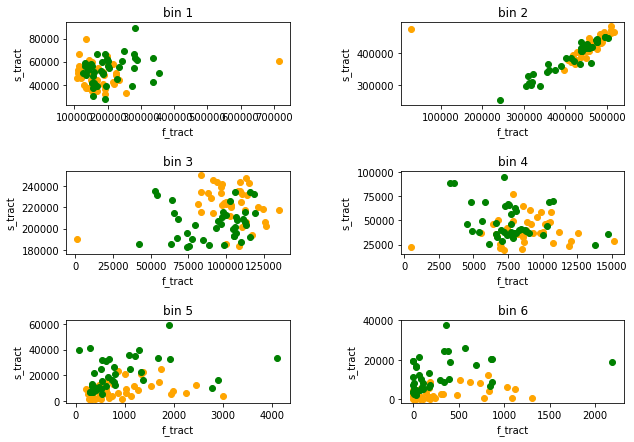

In [4]:
#plot of 6 histograms. I put 6 bins in my fucntion and I'm comparing each both classes in each scatterplot
plt.figure(figsize=(10, 7))
plt.subplots_adjust(wspace=0.5, hspace=0.8)
plt.subplot(321)
frecuency_bin_plot(0,6)
plt.subplot(322)
frecuency_bin_plot(1,6)
plt.subplot(323)
frecuency_bin_plot(2,6)
plt.subplot(324)
frecuency_bin_plot(3,6)
plt.subplot(325)
frecuency_bin_plot(4,6)
plt.subplot(326)
frecuency_bin_plot(5,6)
plt.show()

These plots show the comparision of frecuencies from the 2 selected classes (dog orange cat green), and in each plot contains the frecuencies corresponding to the same bin. 

# Split in training and testing data, and SVM implementation

The labeled datasets were con-sequently arranged into 5 uniformly sized cross-validation folds, ensuring that clips originating from the same initial source file are always contained in a single fold, therefore, choosing the ammount of data that I take for training and for testing should not separate files from the same fold. The more folds I choose for training the more accurate my algorithm is going to make predictions, and the more folds I use for testing the more accurate are going to be the restults of my testing, and consecuently, I neeed to find a balance. For this assignment I choose 3 folds for training and 2 folds for testing.

In the SVM implementation I can variate C and gamma (parameters 'c' and 'gamma'):

C controls tradeoff between smooth decision boundary and classifying points correctly. I can draw somthing that can be very straight but it comes at the cost of a few points being missclassified. I can draw something more wiggely where I get all of the training points correct, but it's not going to generalize well to my training set.

Gamma defines how far the influence of a single training sample reaches. If it is low, every point has a far reach. If it is high, every training point has a close reach. For a high gamma,the details of the decision boundary are just going to be dependent on the points that are the very closest to it. For a low value of gamma, then even the far away data points are taking into consideration for drawing the decision bounday. For high values of gamma, I can obtain a wiggly decision boundary, for low values of gamma I can obtain a more linear and smoother decision boundary.



In [61]:
def train_test_svm(bins,c,gamma):
    csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
    fold_cat = pd.DataFrame(csv, columns= ['fold','category'])
    cat = ['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening']
    cnt=0
    cnt2=0
    cnt3=0
    cnt4=0
    dog_training=np.zeros([24,(bins*2)])#24 files from this group
    cat_training=np.zeros([24,(bins*2)])#24 files from this group
    dog_testing=np.zeros([16,(bins*2)])#16 files from this group
    cat_testing=np.zeros([16,(bins*2)])#16 files from this group
    for index, row in fold_cat.iterrows():
        categories = row['category']
        folds=row['fold']
        if(categories=='dog' and (folds==1 or folds==2 or folds==3)): #dog training
            filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
            ff = h5py.File(filenamej,"r")
            fT=ff["f_tract"][6:94,:].flatten()
            sT=ff["s_tract"][6:94,:].flatten()
            frequency_f,b = np.histogram(fT, bins=bins)
            frequency_s,b = np.histogram(sT, bins=bins)
            dog_training[cnt]=np.append(frequency_f,frequency_s,axis=0)#frecuencies from the bins (both f_tract and s_tract) for the files from dog class and folds 1,2 and 3
            cnt+=1
        if(categories=='dog' and (folds==4 or folds==5)): #dog testing
            filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
            ff = h5py.File(filenamej,"r")
            fT=ff["f_tract"][6:94,:].flatten()
            sT=ff["s_tract"][6:94,:].flatten()
            frequency_f,b = np.histogram(fT, bins=bins)
            frequency_s,b = np.histogram(sT, bins=bins)
            dog_testing[cnt2]=np.append(frequency_f,frequency_s,axis=0)#frecuencies from the bins (both f_tract and s_tract) for the files from dog class and folds 4 and 5
            cnt2+=1
        if(categories=='cat'and (folds==1 or folds==2 or folds==3)): #cat training
            filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
            ff = h5py.File(filenamej,"r")
            fT=ff["f_tract"][6:94,:].flatten()
            sT=ff["s_tract"][6:94,:].flatten()
            frequency_f,b = np.histogram(fT, bins=bins)
            frequency_s,b = np.histogram(sT, bins=bins)
            cat_training[cnt3]=np.append(frequency_f,frequency_s,axis=0)#frecuencies from the bins (both f_tract and s_tract) for the files from cat class and folds 1,2 and 3
            cnt3+=1
        if(categories=='cat'and (folds==4 or folds==5)): #cat testing
            filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
            ff = h5py.File(filenamej,"r")
            fT=ff["f_tract"][6:94,:].flatten()
            sT=ff["s_tract"][6:94,:].flatten()
            frequency_f,b = np.histogram(fT, bins=bins)
            frequency_s,b = np.histogram(sT, bins=bins)
            cat_testing[cnt4]=np.append(frequency_f,frequency_s,axis=0)#frecuencies from the bins (both f_tract and s_tract) for the files from cat class and folds 4 and 5
            cnt4+=1
    #this is how I composed the training and testing data
    x_train=np.append(dog_training,cat_training,axis=0)
    y_train=np.transpose(np.array(cnt*['dog']+cnt3*['cat']))
    x_test=np.append(dog_testing,cat_testing,axis=0)
    y_test=np.transpose(np.array(cnt2*['dog']+cnt4*['cat']))
    
    #SVM implementation using a sk learn tool
    svm = SVC(C=c,gamma=gamma,kernel='linear' )#I used a linear kernel
    svm.fit(x_train,y_train)
    y_pred = svm.predict(x_test)
    print('bins: '+format(bins)+'| C: '+format(c)+'| Gamma: '+format(gamma))
    print('accuracy score = ', accuracy_score(y_test,y_pred))
    print('________________________________________________________________')

Now I am going to variate the prameters of the previous functions (with variating the number of bins I am also variating the number of features)

Now I can variate my features by selecting the desired number of bins.

Note: I have tried variating the kernel (rbf, linear and poly) but the linear kernel always gives the best results in this case

# SVM implementation. Comparison with different parameters, C and gamma values

I proceed to compare the accuracy of the algorithm, by variating the parameters of the function train_test_svm that I obtained previously. Testing this algorithm takes some computational power and time, therefore I had to simplify it as much as I was able to, but trying to give an acceptable comparison.

Variation of the parameter 'bins': Results for 8, 6 and 4 bins. C=1 and gamma='auto'.


In [48]:
train_test_svm(10, 1, 'auto')

bins: 10| C: 1| Gamma: auto
accuracy score =  0.84375
________________________________________________________________


In [49]:
train_test_svm(8, 1, 'auto')

bins: 8| C: 1| Gamma: auto
accuracy score =  0.90625
________________________________________________________________


In [46]:
train_test_svm(6, 1, 'auto')

bins: 6| C: 1| Gamma: auto
accuracy score =  0.90625
________________________________________________________________


In [47]:
train_test_svm(4, 1, 'auto')

bins: 4| C: 1| Gamma: auto
accuracy score =  0.875
________________________________________________________________


We can observe that increasing the number of bins (more features) does not always increase the accuracy. I obtained the best results for 8 and 6 bins using a linear kerner on the SVM algorithm.

Variation of the parameter 'gamma': Results for gamma values of 1/6, 1/9 and 1/14. The 'auto' value of gamma was 1/n_features, which is in this case would be 1/12 for 6 bins. bins=6 and C=1

In [50]:
train_test_svm(6, 1, (1/6))

bins: 6| C: 1| Gamma: 0.16666666666666666
accuracy score =  0.90625
________________________________________________________________


In [51]:
train_test_svm(6, 1, (1/9))

bins: 6| C: 1| Gamma: 0.1111111111111111
accuracy score =  0.90625
________________________________________________________________


In [52]:
train_test_svm(6, 1, 1/14)

bins: 6| C: 1| Gamma: 0.07142857142857142
accuracy score =  0.90625
________________________________________________________________


Variating gamma in these cases does not seem to have an impact on the accuracy score

Variation of the parameter C. Results for C values of 0.2, 0.5 and 1.5. bins=6 and gamma='auto'

In [63]:
train_test_svm(6, 0.2, 'auto')

bins: 6| C: 0.2| Gamma: auto
accuracy score =  0.90625
________________________________________________________________


In [64]:
train_test_svm(6, 0.5, 'auto')

bins: 6| C: 0.5| Gamma: auto
accuracy score =  0.90625
________________________________________________________________


In [65]:
train_test_svm(6, 1.5, 'auto')

bins: 6| C: 1.5| Gamma: auto
accuracy score =  0.90625
________________________________________________________________


In [66]:
train_test_svm(6, 3, 'auto')

bins: 6| C: 3| Gamma: auto
accuracy score =  0.90625
________________________________________________________________


In [69]:
train_test_svm(6, 3000, 'auto')

bins: 6| C: 3000| Gamma: auto
accuracy score =  0.90625
________________________________________________________________


In [62]:
train_test_svm(6, pow(3000,-1), 'auto')

bins: 6| C: 0.0003333333333333333| Gamma: auto
accuracy score =  0.90625
________________________________________________________________


In my model variating C does for the previous values does not seem to have an impact on the accuracy score

# Comparison with K-means turned into a classifier based on a majority vote

In the following cell I am obtaining the training data the same way I did in the train_test_svm, so I can use it in my majority vote K-means algorithm

In [2]:
"""
Same as before in train_test_svm but setting 6 bins, C=1 and gamma='auto'

"""
bins=6
c=1
gamma='auto'
csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
fold_cat = pd.DataFrame(csv, columns= ['fold','category'])
cnt=0
cnt2=0
cnt3=0
cnt4=0
dog_training=np.zeros([24,(bins*2)])#24 files from this group
cat_training=np.zeros([24,(bins*2)])#24 files from this group
dog_testing=np.zeros([16,(bins*2)])#16 files from this group
cat_testing=np.zeros([16,(bins*2)])#16 files from this group
for index, row in fold_cat.iterrows():
    categories = row['category']
    folds=row['fold']
    if(categories=='dog' and (folds==1 or folds==2 or folds==3)): #dog training
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        fT=ff["f_tract"][6:94,:].flatten()
        sT=ff["s_tract"][6:94,:].flatten()
        frequency_f,b = np.histogram(fT, bins=bins)
        frequency_s,b = np.histogram(sT, bins=bins)
        dog_training[cnt]=np.append(frequency_f,frequency_s,axis=0)#frecuencies from the bins (both f_tract and s_tract) for the files from dog class and folds 1,2 and 3
        cnt+=1
    if(categories=='dog' and (folds==4 or folds==5)): #dog testing
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        fT=ff["f_tract"][6:94,:].flatten()
        sT=ff["s_tract"][6:94,:].flatten()
        frequency_f,b = np.histogram(fT, bins=bins)
        frequency_s,b = np.histogram(sT, bins=bins)
        dog_testing[cnt2]=np.append(frequency_f,frequency_s,axis=0)#frecuencies from the bins (both f_tract and s_tract) for the files from dog class and folds 4 and 5
        cnt2+=1
    if(categories=='cat'and (folds==1 or folds==2 or folds==3)): #cat training
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        fT=ff["f_tract"][6:94,:].flatten()
        sT=ff["s_tract"][6:94,:].flatten()
        frequency_f,b = np.histogram(fT, bins=bins)
        frequency_s,b = np.histogram(sT, bins=bins)
        cat_training[cnt3]=np.append(frequency_f,frequency_s,axis=0)#frecuencies from the bins (both f_tract and s_tract) for the files from cat class and folds 1,2 and 3
        cnt3+=1
    if(categories=='cat'and (folds==4 or folds==5)): #cat testing
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        fT=ff["f_tract"][6:94,:].flatten()
        sT=ff["s_tract"][6:94,:].flatten()
        frequency_f,b = np.histogram(fT, bins=bins)
        frequency_s,b = np.histogram(sT, bins=bins)
        cat_testing[cnt4]=np.append(frequency_f,frequency_s,axis=0)#frecuencies from the bins (both f_tract and s_tract) for the files from cat class and folds 4 and 5
        cnt4+=1
#this is how I composed the training and testing data
x_train=np.append(dog_training,cat_training,axis=0)
y_train=np.transpose(np.array(cnt*['dog']+cnt3*['cat']))
x_test=np.append(dog_testing,cat_testing,axis=0)
y_test=np.transpose(np.array(cnt2*['dog']+cnt4*['cat']))


K means sklearn tool. I obatined the labels

In [30]:
n_clusters = 20
k_means = KMeans(n_clusters=n_clusters, n_init=10).fit(x_train)
labels=k_means.labels_
print(labels)

[15  8  6 16 19 10  6  9 17  3  2 10  2  8 10 12 10  6  5 16  8  2  9 11
 18 14  7  4  1  3  9  0  1  1  3  9  1  1  4 16 12  4  5  4 13 13  7 13]


I create a Data Frame with the original class and k label values

In [31]:
OriginalClass=pd.DataFrame(y_train,columns=['Original_Class'])
klabel=pd.DataFrame(labels,columns=['k_label'])
OriginalClass_klabel=pd.concat((OriginalClass,klabel),axis=1)
OriginalClass_klabel

,Original_Class,k_label
0,dog,15
1,dog,8
2,dog,6
3,dog,16
4,dog,19
5,dog,10
6,dog,6
7,dog,9
8,dog,17
9,dog,3


I create a new column in the Data Frame with the predicted values. For this, I use the 'mayority vote', selecting, for each k_label value the most repeated Original_Class value throughout the data frame

In [32]:
mode_k=list()
for i in range(n_clusters):
    mode_k.append(OriginalClass_klabel[OriginalClass_klabel.k_label==i].Original_Class.mode()[0])
predicted=list()
for index,row in OriginalClass_klabel.iterrows():
    k_val=row['k_label']
    predicted.append(mode_k[k_val])
predicted_df=pd.DataFrame(predicted, columns=['Predicted_class'])
OriginalClass_klabel_pred=pd.concat((OriginalClass_klabel,predicted_df),axis=1)
OriginalClass_klabel_pred

,Original_Class,k_label,Predicted_class
0,dog,15,dog
1,dog,8,dog
2,dog,6,dog
3,dog,16,dog
4,dog,19,dog
5,dog,10,dog
6,dog,6,dog
7,dog,9,cat
8,dog,17,dog
9,dog,3,cat


Now I can make a confusion matrix that also shows the accuracy of my k-means algorithm 

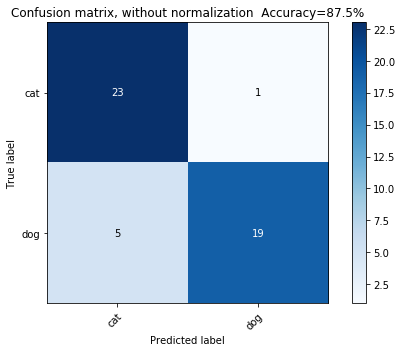

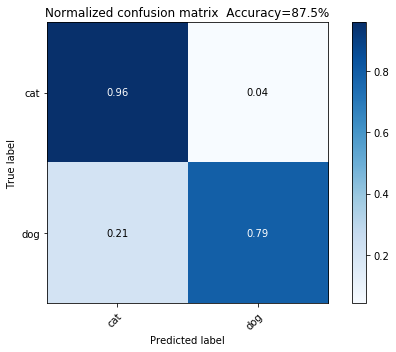

In [33]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
cat = ['cat', 'dog']
#list of true values that's going inside the confusion matrix
true_list=list() 
for index, row in OriginalClass_klabel_pred.iterrows():
    Original_Class=row['Original_Class']
    for i in range(len(cat)):
        if(cat[i]==Original_Class):
            true_list.append(i)
            
#list of predicted values that's going inside the confusion matrix            
pred_list=list()
for index, row in OriginalClass_klabel_pred.iterrows():
    Predicted_Class=row['Predicted_class']
    for i in range(len(cat)):
        if(cat[i]==Predicted_Class):
            pred_list.append(i)
            
cat_names= np.array(cat)#array of categories



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix  '
        else:
            title = 'Confusion matrix, without normalization  '

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
   
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(7,5))
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title+'Accuracy='+np.array2string(100*(np.trace(cm)/np.sum(cm)),precision=1)+'%',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
    


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(true_list, pred_list, classes=cat_names)
# Plot normalized confusion matrix
plot_confusion_matrix(true_list, pred_list, classes=cat_names, normalize=True)

plt.show()

With 4 clusters I obtain an accuracy of 79.2%

with 8 clusters I obtain the same accuracy

with 20 clusters I obtain an accuracy of 91.7%

25 clusters accuracy 89.6%

18 clusters-83.3% accuracy

22 clusters-89.6% accuracy

Every time I repeat the k-means algorithm I obtain a slightly different result, but the best accuracy is always around 20 clusters

**Comparison**: This accuracy with 20 clusters is approximately 90%, which is slightly lower than the 90.625% that I obtained with the SVM algorithm, using 6 bins.

Result for Acoustic Event Detection Challenge challenge: SVM gives slightly better results and the time it takes to compute the function I created for it is not excessive.